In [1]:
## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/qg-jets/QG_jets.npz


In [2]:
!pip install dgl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 53.8 MB/s eta 0:00:0000:0100:01


In [3]:
import torch
import numpy as np
import networkx as nx
import scipy.sparse as sp
import torch.nn as nn
import dgl.nn as dglnn
import torch.nn.functional as F
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from dgl.data.utils import save_graphs, load_graphs
from dgl.nn.pytorch.conv import GraphConv
%matplotlib inline
import matplotlib.pyplot as plt

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [4]:
dataset = dict(np.load('/kaggle/input/qg-jets/QG_jets.npz'))
X, y = dataset['X'], {'label': torch.tensor(dataset['y']).long()}

In [5]:
import dgl
import networkx as nx
from dgl.data.utils import save_graphs, load_graphs

# https://github.com/dmlc/xgboost/issues/1715
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

class GenerateGraphs(object):
    def describe(self): return self.__class__.__name__
    def __init__(self, data, connect_style):
        '''
          Args:
            data: np.ndarry
              input data
            connect_style: str
              Type of edge connections
        '''
        self.data = data
        self.label_name = 'label'
        self.feature_name = 'feature'
        self.connect_style = connect_style
        self._current_data = None

    def _assign_node_feature(self, graph):
        ''' Each node presents a b-jet with four momentum and b-tagging score as features.
        '''
        feature_name = 'feature'
        assert(self._current_data is not None)
        graph.ndata[feature_name] = torch.tensor(self._current_data)
        return graph

    def _create_graph(self, ievent: int):
        ''' Create a graph from a jet X [track multiplicity, "4-momentum"], where "4-momentum" is pt, rapidity, azimuthal angle, and pdgid.
            data: https://zenodo.org/record/3164691#.YFeQey1Q0lp
        '''
        self._current_data = self.data[ievent][~np.all(self.data[ievent] == 0, axis=1)]

        ''' Feature preprocessing: Sect 3.1 in https://arxiv.org/pdf/1810.05165.pdf
            centering jets and normalizing pT
            https://energyflow.network/examples/
        '''
        yphi_avg = np.average(self._current_data[:,1:3], weights=self._current_data[:,0], axis=0)
        self._current_data[:,1:3] -= yphi_avg
        self._current_data[:, 0] /= np.sum(self._current_data[:, 0])

        ''' - Sort by pT (0th column) '''
        self._current_data = self._current_data[self._current_data[:,0].argsort()][::-1].copy()

        ''' Construct a graph '''
        n_nodes = self._current_data.shape[0] # track multiplicity
        if self.connect_style == 'bifully':
            ''' Option 1: Fully connected graph '''
            g = nx.complete_graph(n_nodes)
            graph = dgl.from_networkx(g)
        else:
            ''' Option 2: Bi-directional connection in adjacent track in pT or eta or phi'''
            pt_order = self._current_data[:,0].argsort()[::-1]
            rapidity_order = self._current_data[:,1].argsort()[::-1]
            eta_order = self._current_data[:,2].argsort()[::-1]

            if self.connect_style == 'biadj_pt_y_phi':
                in_node  = np.concatenate((pt_order[:-1], rapidity_order[:-1], eta_order[:-1]))
                out_node = np.concatenate((pt_order[1: ], rapidity_order[1: ], eta_order[1: ]))
            elif self.connect_style == 'biadj_pt_y':
                in_node  = np.concatenate((pt_order[:-1], rapidity_order[:-1]))
                out_node = np.concatenate((pt_order[1: ], rapidity_order[1: ]))
            elif self.connect_style == 'biadj_pt_phi':
                in_node  = np.concatenate((pt_order[:-1], eta_order[:-1]))
                out_node = np.concatenate((pt_order[1: ], eta_order[1: ]))
            elif self.connect_style == 'biadj_y_phi':
                in_node  = np.concatenate((rapidity_order[:-1], eta_order[:-1]))
                out_node = np.concatenate((rapidity_order[1: ], eta_order[1: ]))

            g = dgl.graph(( in_node, out_node), num_nodes=n_nodes)
            g = dgl.add_reverse_edges(g)
            graph = dgl.add_self_loop(g)


        ''' Assign node feature using "current data" '''
        graph = self._assign_node_feature(graph)

        return graph.int() # 32-bit integers for node and edge IDs to reduce memory

    def create_graphs(self, stop=None):
        ''' Create all graphs for all events.
        '''

        ''' PDGid to small float dictionary https://github.com/pkomiske/EnergyFlow/blob/master/energyflow/utils/data_utils.py#L188 '''
        PID2FLOAT_MAP = {22: 0,
                    211: .1, -211: .2,
                    321: .3, -321: .4,
                    130: .5,
                    2112: .6, -2112: .7,
                    2212: .8, -2212: .9,
                    11: 1.0, -11: 1.1,
                    13: 1.2, -13: 1.3,
                    0: 0,}
        for pid in np.unique(self.data[:, :, 3].flatten()):
            np.place(self.data[:, :, 3], self.data[:, :, 3] == pid, PID2FLOAT_MAP[pid])

        graphs = []
        n_graphs = min(stop, self.data.shape[0]) if stop else self.data.shape[0]
        
        for i in range(n_graphs):
            if i % 1000 == 0:
                print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '\033[92m[INFO]\033[0m', f'\033[92mCreated {self.connect_style} graphs:\033[0m'.rjust(40, ' '),  i, '/', n_graphs)
            graph = self._create_graph(i)
            graphs.append(graph)
        return graphs

In [6]:
generator = GenerateGraphs(X, connect_style='biadj_pt_y_phi')
graphs = generator.create_graphs()

2024-03-26 12:39:45 [INFO]  Created biadj_pt_y_phi graphs: 0 / 100000
2024-03-26 12:39:47 [INFO]  Created biadj_pt_y_phi graphs: 1000 / 100000
2024-03-26 12:39:48 [INFO]  Created biadj_pt_y_phi graphs: 2000 / 100000
2024-03-26 12:39:49 [INFO]  Created biadj_pt_y_phi graphs: 3000 / 100000
2024-03-26 12:39:50 [INFO]  Created biadj_pt_y_phi graphs: 4000 / 100000
2024-03-26 12:39:52 [INFO]  Created biadj_pt_y_phi graphs: 5000 / 100000
2024-03-26 12:39:53 [INFO]  Created biadj_pt_y_phi graphs: 6000 / 100000
2024-03-26 12:39:54 [INFO]  Created biadj_pt_y_phi graphs: 7000 / 100000
2024-03-26 12:39:55 [INFO]  Created biadj_pt_y_phi graphs: 8000 / 100000
2024-03-26 12:39:57 [INFO]  Created biadj_pt_y_phi graphs: 9000 / 100000
2024-03-26 12:39:58 [INFO]  Created biadj_pt_y_phi graphs: 10000 / 100000
2024-03-26 12:39:59 [INFO]  Created biadj_pt_y_phi graphs: 11000 / 100000
2024-03-26 12:40:01 [INFO]  Created biadj_pt_y_phi graphs: 12000 / 100000
2024-03-26 12:40:02 [INFO]  Created biadj_pt_y_phi 

In [24]:
#Dataset train, test valodation split
train_size = int(len(graphs) * 0.7)
val_size = int(len(graphs) * 0.2)
test_size = len(graphs) - train_size - val_size

dataset = list(zip(graphs, y['label']))
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, (train_size, val_size, test_size))

#batch size =1
train_dataloader = dgl.dataloading.GraphDataLoader(train_dataset, batch_size = train_size, drop_last=False, shuffle=True)
val_dataloader = dgl.dataloading.GraphDataLoader(val_dataset, batch_size = val_size, drop_last=False, shuffle=False)
test_dataloader = dgl.dataloading.GraphDataLoader(test_dataset, batch_size = test_size, drop_last=False, shuffle=False)

print('Train size: ', train_size)
print('Validation size: ', val_size)
print('Test size: ', test_size)

Train size:  70000
Validation size:  20000
Test size:  10000


In [25]:
class GAT(nn.Module):
    ''' Two layers of Graph Attention Network.
        https://docs.dgl.ai/api/python/nn.pytorch.html#gatconv
    '''
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        # input shape = (nodes, features=in_feats); output shape = (nodes, num_head, hid_feats)
        self.gatconv1 = dglnn.GATConv(in_feats, hid_feats, num_heads=2)
        # input shape = (nodes, hid_feats * num_heads_previous_layer); output shape = (nodes, num_head, out_feats)
        self.gatconv2 = dglnn.GATConv(hid_feats * 2, out_feats, num_heads=1)

    def forward(self, graph, inputs):
        # input shape = (nodes , features)
        # print('inputs', inputs.shape, inputs)
        h = self.gatconv1(graph, inputs)
        # here h shape = (nodes, num_head, hid_feats)
        # print('h1', h.shape, h)
        ''' Reshape h to flatten the num_heads '''
        # here h shape = (nodes, num_head * hid_feats)
        h = h.reshape(h.shape[0], np.prod(h.shape[1:]))
        # print('h2', h.shape, h)
        h = self.gatconv2(graph, h)
        # print('h3', h.shape, h)

        graph.ndata['tmp_feature'] = h
        h = dgl.mean_nodes(graph, 'tmp_feature')
        # print('h4', h.shape, h)
        h = torch.sigmoid(h)
        h = torch.squeeze(h)
        # print('h9', h.shape, h)
        return h

class AGNNConv(nn.Module):
    ''' Graph Attention Network.
        https://docs.dgl.ai/api/python/nn.pytorch.html#agnnconv
    '''
    def __init__(self):
        super().__init__()

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = AGNNConv()(graph, inputs)
        h = torch.sigmoid(h)
        return h

In [26]:
class GNNmodel(nn.Module):
    def __init__(self, module, in_features, hidden_features, out_features, name='GNN'):
        super().__init__()
        
        self.name = name
        if module.lower() == 'gat':
            # from dgl.nn import GATConv
            self.module = GAT(in_features, hidden_features, out_features)
        else:
            assert False, module + ' is not supported'

    def forward(self, g, x):
        h = self.module(g, x)
        return torch.squeeze(h) #self.pred(g, h)

In [27]:
def train(model, optimizer, epochs=100, loss_func=nn.MSELoss()):
  epoch_losses = {'train': [], 'val': []}
  for epoch in range(epochs):
      train_loss = 0
      for ibatch, (batched_graph, labels) in enumerate(train_dataloader):
          node_features = batched_graph.ndata['feature']
          pred = model(batched_graph, node_features.float())
          loss = loss_func(pred, labels.float())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          train_loss += loss.detach().item()

      # The loss per epoch for all batch is the average of losses per batch in this epoch 
      train_loss /= (ibatch + 1)

      # Store loss per epoch 
      epoch_losses['train'].append(train_loss)

      # Evaluate validation loss
      for ibatch, (batched_graph, labels) in enumerate(val_dataloader):
          node_features = batched_graph.ndata['feature']
          pred = model(batched_graph, node_features.float())
          val_loss = loss_func(pred, labels.float()).detach().item()
          epoch_losses['val'].append(val_loss)
          assert(ibatch == 0)

      print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '\033[92m[INFO]\033[0m', '\033[92mepoch, loss, val_loss:\033[0m'.rjust(40, ' '),  epoch+1, '|', train_loss, '|', val_loss)
  return epoch_losses

In [28]:
 # define test loop
 def test(model, loss_func=nn.MSELoss()):
    epoch_losses = {'test': []}
    with torch.no_grad():
        ''' Final Evaluate train loss '''
        train_pred = []
        train_labels = []
        for ibatch, (batched_graph, labels) in enumerate(train_dataloader):
            node_features = batched_graph.ndata['feature']
            pred = model(batched_graph, node_features.float()).detach()
            # print('zhangr train pred', pred.shape, pred)
            # print('zhangr train labels', labels.shape, labels)
            train_pred.append(pred)
            train_labels.append(labels)
        train_pred = torch.cat(train_pred).numpy()
        train_labels = torch.cat(train_labels).numpy()

        ''' Final Evaluate val loss '''
        val_pred = []
        val_labels = []
        for ibatch, (batched_graph, labels) in enumerate(train_dataloader):
            node_features = batched_graph.ndata['feature']
            pred = model(batched_graph, node_features.float()).detach()
            val_pred.append(pred)
            val_labels.append(labels)
            assert(ibatch == 0)
        val_pred = torch.cat(val_pred).numpy()
        val_labels = torch.cat(val_labels).numpy()


        ''' Evaluate test loss '''
        test_pred = []
        test_labels = []
        for ibatch, (batched_graph, labels) in enumerate(test_dataloader):
            node_features = batched_graph.ndata['feature']
            pred = model(batched_graph, node_features.float()).detach()
            test_loss = loss_func(pred, labels.float()).detach().item()
            epoch_losses['test'].append(test_loss)
            test_pred.append(pred)
            test_labels.append(labels)
            assert(ibatch == 0)
        test_pred = torch.cat(test_pred).numpy()
        test_labels = torch.cat(test_labels).numpy()
    return epoch_losses, train_pred, train_labels, val_pred, val_labels, test_pred, test_labels

In [29]:
hidden_features, out_features = 9, 1 # 2 = classifier predict
torch.manual_seed(0)
# create the model
gat_model = GNNmodel('GAT', graphs[0].ndata[list(graphs[0].ndata.keys())[0]].shape[1], hidden_features, out_features, name='GAT')
print('Node feature dimension evolution {}->{}->{}'.format(graphs[0].ndata[list(graphs[0].ndata.keys())[0]].shape[1], hidden_features, out_features))

Node feature dimension evolution 4->9->1


In [30]:
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.1)

In [31]:
losses = train(gat_model, optimizer)

2024-03-26 12:49:32 [INFO]          epoch, loss, val_loss: 1 | 0.2504371106624603 | 0.285297691822052
2024-03-26 12:49:40 [INFO]          epoch, loss, val_loss: 2 | 0.2871972620487213 | 0.2491440623998642
2024-03-26 12:49:49 [INFO]          epoch, loss, val_loss: 3 | 0.249580517411232 | 0.2537502944469452
2024-03-26 12:49:57 [INFO]          epoch, loss, val_loss: 4 | 0.25292521715164185 | 0.25930121541023254
2024-03-26 12:50:05 [INFO]          epoch, loss, val_loss: 5 | 0.25819337368011475 | 0.25268983840942383
2024-03-26 12:50:13 [INFO]          epoch, loss, val_loss: 6 | 0.25187021493911743 | 0.2460976392030716
2024-03-26 12:50:21 [INFO]          epoch, loss, val_loss: 7 | 0.2458055019378662 | 0.24590609967708588
2024-03-26 12:50:30 [INFO]          epoch, loss, val_loss: 8 | 0.24615950882434845 | 0.24681897461414337
2024-03-26 12:50:38 [INFO]          epoch, loss, val_loss: 9 | 0.24731841683387756 | 0.24265095591545105
2024-03-26 12:50:46 [INFO]          epoch, loss, val_loss: 10 | 0

In [32]:
test_losses, train_pred, train_labels, val_pred, val_labels, test_pred, test_labels = test(gat_model)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.10/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

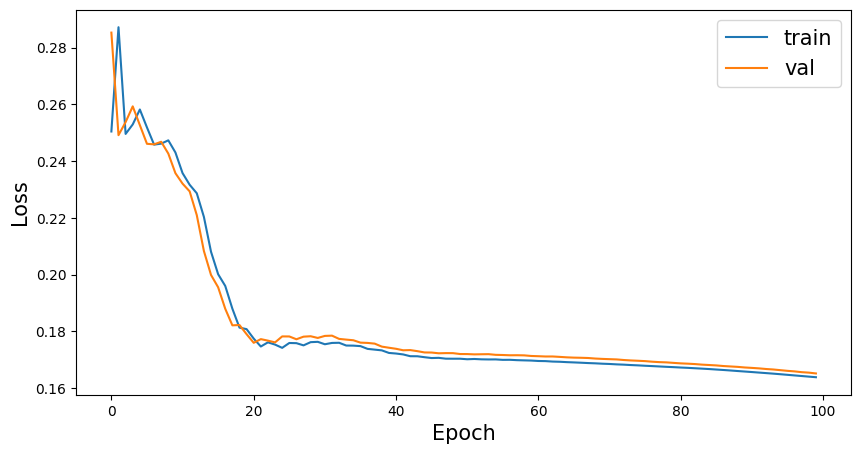

In [33]:

# Plot the loss over time
def plot_loss(*losses, labels=None):
    plt.clf()
    fig = plt.figure(figsize=(10, 5))
    for loss in losses:
        plt.plot(loss)
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    if labels:
      plt.legend(labels, loc='upper right', fontsize=15)
    return plt


plot_loss(losses['train'], losses['val'], labels=['train', 'val'])